# LSTM Model

In [1]:
# change to the directory of the working file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# import the necessary modules
from utils.utils import *
from datasets.data_loader import *
from models.lstm import LSTM_Variant
from utils.plot_figures import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
# load the data
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

cudnn.benchmark = True
lr = 4e-6
batch_size = 512
epoch = 10
seqlen = 127

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load the training and testing data
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the model
model = LSTM_Variant(charlen, embedding_dim=256, hidden_dim=256, conditional_synthesis_dim=24, num_layers=2, dropout=0.2)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=char_to_index['?']) # ignore the padding index
optimizer = optim.Adam(model.parameters(), lr=lr)

# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    model = model.to(device)
    criterion = criterion.to(device)

total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))  # print the total parameters

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29
cuda
total parameters: 1.34M


In [5]:
# train function
def train(model, train_dataloader, loss_func, optimizer, device):
    model.train()
    total_loss = 0
    total_corrects = 0
    total_words = 0

    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        zeo, syn, tgt = zeo.to(device), syn.to(device), tgt.to(device)
        
        # Concatenate zeolite and synthesis condition
        condition_synthesis = torch.cat([zeo, syn], dim=1)
        tgt_input = tgt[:, :-1].contiguous()  # Remove the last token
        tgt_label = tgt[:, 1:].contiguous()  # Remove the first token

        # Forward pass
        output, _ = model(condition_synthesis, tgt_input)
        loss = loss_func(output.reshape(-1, output.size(2)), tgt_label.reshape(-1))
        
        # Calculate the accuracy
        pred = output.argmax(dim=-1)
        # the number of corrects which is not padding
        num_corrects = ((pred == tgt_label) & (tgt_label != 0)).sum().item()
        # the number of words which is not padding
        num_words = (tgt_label != 0).sum().item()

        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Log the loss and accuracy
        total_loss += loss.item()
        total_corrects += num_corrects
        total_words += num_words

    # Calculate average loss and overall accuracy
    avg_loss = total_loss / len(train_dataloader)
    avg_acc = total_corrects / total_words
    return avg_loss, avg_acc

In [6]:
# evaluate function
def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo, syn, tgt = zeo.to(device), syn.to(device), tgt.to(device)
            # concat the zeolite and synthesis condition
            condition_synthesis = torch.cat([zeo, syn], dim=1)
            tgt_input = tgt[:, :-1].contiguous() # remove the last token
            tgt_label = tgt[:, 1:].contiguous() # remove the first token
            # forward
            output, _ = model(condition_synthesis, tgt_input)
            loss = loss_func(output.reshape(-1, output.size(2)), tgt_label.reshape(-1))
            # calculate the accuracy
            pred = output.argmax(dim=-1)
            # the number of corrects which is not padding
            num_corrects = ((pred == tgt_label) & (tgt_label != 0)).sum().item()
            # the number of words which is not padding
            num_words = (tgt_label != 0).sum().item()
            # log the loss and accuracy
            total_loss += loss.item()
            total_acc += num_corrects
            total_num += num_words
    avg_loss = total_loss / len(test_dataloader)
    avg_acc = total_acc / total_num
    return avg_loss, avg_acc

In [7]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train_loss: %.4f, train_acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d, test_loss: %.4f, test_acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_loss = test_loss
        best_acc = test_acc
    if test_loss < best_loss:
        best_loss = test_loss
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'lstm_variant_best_loss.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'lstm_variant_last.pth')

100%|██████████| 284/284 [00:05<00:00, 54.60it/s]


epoch: 0, train_loss: 3.2456, train_acc: 0.2978


100%|██████████| 68/68 [00:00<00:00, 176.73it/s]


epoch: 0, test_loss: 3.0445, test_acc: 0.3532


100%|██████████| 284/284 [00:05<00:00, 55.31it/s]


epoch: 1, train_loss: 2.6689, train_acc: 0.3690


100%|██████████| 68/68 [00:00<00:00, 190.02it/s]


epoch: 1, test_loss: 2.4247, test_acc: 0.3767


100%|██████████| 284/284 [00:05<00:00, 55.29it/s]


epoch: 2, train_loss: 2.3358, train_acc: 0.3743


100%|██████████| 68/68 [00:00<00:00, 175.48it/s]


epoch: 2, test_loss: 2.2662, test_acc: 0.3767


100%|██████████| 284/284 [00:05<00:00, 55.64it/s]


epoch: 3, train_loss: 2.2207, train_acc: 0.3744


100%|██████████| 68/68 [00:00<00:00, 189.04it/s]


epoch: 3, test_loss: 2.1714, test_acc: 0.3773


100%|██████████| 284/284 [00:05<00:00, 55.40it/s]


epoch: 4, train_loss: 2.1309, train_acc: 0.3783


100%|██████████| 68/68 [00:00<00:00, 172.51it/s]


epoch: 4, test_loss: 2.0814, test_acc: 0.3859


100%|██████████| 284/284 [00:05<00:00, 55.43it/s]


epoch: 5, train_loss: 2.0443, train_acc: 0.3917


100%|██████████| 68/68 [00:00<00:00, 189.19it/s]


epoch: 5, test_loss: 1.9960, test_acc: 0.4068


100%|██████████| 284/284 [00:05<00:00, 55.01it/s]


epoch: 6, train_loss: 1.9630, train_acc: 0.4134


100%|██████████| 68/68 [00:00<00:00, 189.10it/s]


epoch: 6, test_loss: 1.9165, test_acc: 0.4207


100%|██████████| 284/284 [00:05<00:00, 55.15it/s]


epoch: 7, train_loss: 1.8868, train_acc: 0.4380


100%|██████████| 68/68 [00:00<00:00, 175.86it/s]


epoch: 7, test_loss: 1.8421, test_acc: 0.4635


100%|██████████| 284/284 [00:05<00:00, 54.59it/s]


epoch: 8, train_loss: 1.8151, train_acc: 0.4791


100%|██████████| 68/68 [00:00<00:00, 188.94it/s]


epoch: 8, test_loss: 1.7723, test_acc: 0.4985


100%|██████████| 284/284 [00:05<00:00, 54.99it/s]


epoch: 9, train_loss: 1.7478, train_acc: 0.5039


100%|██████████| 68/68 [00:00<00:00, 174.78it/s]


epoch: 9, test_loss: 1.7071, test_acc: 0.5159


In [8]:
# generate smiles by the model
def generate_smiles(model, zeo, syn, char_to_index, index_to_char, max_length, device):
    model.eval()
    batch_size = zeo.size(0)
    zeo = zeo.to(device)
    syn = syn.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    input_seq = torch.zeros(batch_size, max_length).long().to(device)
    input_seq[:, 0] = char_to_index['^']
    for i in range(1, max_length):
        output, _ = model(condition_synthesis, input_seq[:, i-1])
        # softmax
        output = output[:, -1, :]
        output = F.softmax(output, dim=-1)
        # sample the next token by max probability
        next_token = output.argmax(dim=-1)
        # Update input_seq
        for j in range(batch_size):
            if input_seq[j, -1] != char_to_index['$']:
                input_seq[j, i] = next_token[j]
        if all(input_seq[:, -1] == char_to_index['$']):
            break
    smiles = []
    print(input_seq)
    for i in range(batch_size):
        smiles.append(''.join([index_to_char[idx] for idx in input_seq[i].cpu().numpy() if idx != 0 and idx != char_to_index['^']]))
    return smiles

In [9]:

def generate_lstm(model, start_sequence, condition_synthesis, max_length, char_to_index, index_to_char, device, temperature=0.5):
    """
    Autoregressive generation function.
    
    Args:
    - model: LSTM_Variant model
    - start_sequence: Initial sequence tensor (batch_size x seq_length)
    - condition_synthesis: Conditional synthesis tensor (batch_size x condition_synthesis_dim)
    - max_length: Maximum sequence length
    - char_to_index: Character-to-index dictionary
    - index_to_char: Index-to-character dictionary
    - device: Device (CPU or GPU)
    - temperature: Temperature scaling factor
    
    Returns:
    - decoded_smiles: List of generated SMILES strings
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_smiles = start_sequence.clone().to(device)  # Initialize generated sequences
    hidden = None  # Initialize LSTM hidden state

    # Initialize termination flags
    is_finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

    for _ in range(max_length - start_sequence.size(1)):
        # Current input: the last token of each sequence
        input_seq = torch.tensor([seq[-1] for seq in generated_smiles], dtype=torch.long, device=device).unsqueeze(1)
        
        # Forward propagation
        output, hidden = model(condition_synthesis, input_seq, hidden)
        
        # Get the output of the last time step and apply temperature scaling
        next_token_logits = output[:, -1, :]
        next_token_probs = F.softmax(next_token_logits / temperature, dim=-1)
        next_token = torch.multinomial(next_token_probs, 1).squeeze(-1)
        
        # Update generated sequences
        for i in range(batch_size):
            if not is_finished[i]:  # If the current sequence is not finished
                token = next_token[i].item()
                generated_smiles[i].append(token)
                if token == char_to_index['$']:  # Check for end-of-sequence token
                    is_finished[i] = True
        
        # Exit early if all sequences are finished
        if is_finished.all():
            break

    # Convert indices to characters, ignoring padding and start tokens
    decoded_smiles = [
        "".join([index_to_char[token] for token in seq if token != char_to_index['^'] and token != char_to_index['?'] and token != char_to_index['$']])
        for seq in generated_smiles
    ]
    return decoded_smiles


In [10]:
# test the generate function
# check the first 10 samples
train_zeo = train_zeo[:10].astype(np.float32)
train_syn = train_syn[:10].astype(np.float32)
zeo = torch.tensor(train_zeo, dtype=torch.float32).to(device)
syn = torch.tensor(train_syn, dtype=torch.float32).to(device)
target_smi = train_smiles[:10]
start_sequence = torch.full((10, 1), char_to_index['^'], dtype=torch.long)
start_sequence = start_sequence.to(device)
condition_synthesis = torch.cat([zeo, syn], dim=1)
generated_smiles = generate_lstm(model, start_sequence, condition_synthesis, seqlen, char_to_index, index_to_char, device, 0.5)
print('target smiles:')
print(target_smi)
print('generated smiles:')
print(generated_smiles)

target smiles:
[['n1(C)c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(C)c1C']
 ['Cn1cc[n+](Cc2ccccc2C[n+]2ccn(C)c2C)c1C']
 ['Cc1n(C)cc[n+]1Cc1c(cccc1)C[n+]1ccn(c1C)C']
 ['c1ccc(c(c1)C[n+]1c(C)n(C)cc1)C[n+]1ccn(c1C)C']
 ['[n+]1(c(n(C)cc1)C)Cc1c(C[n+]2ccn(c2C)C)cccc1']
 ['Cc1n(C)cc[n+]1Cc1ccccc1C[n+]1c(n(cc1)C)C']
 ['Cn1c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(c1C)C']
 ['c1c[n+](Cc2ccccc2C[n+]2c(C)n(cc2)C)c(C)n1C']
 ['n1(cc[n+](c1C)Cc1ccccc1C[n+]1ccn(C)c1C)C']
 ['[n+]1(Cc2c(C[n+]3c(n(cc3)C)C)cccc2)c(C)n(C)cc1']]
generated smiles:
['CnS1C1CCCCCNC(CC1(C$', '1CCCCCC[1+N(C)(CCCCC(C)CCCCCC)CC)CN))$', '([+]1c)C(C[c)c+ccc()))CC)cCCC)CC1CC)32CN(CC$', 'C2C([C22C)CCN(CCC)CCCC)CCCC[)(cC$', 'cFS$', '2)C(cN11CcCCCC$', 'CP[1]NC(Cn2)C(CC1(C)CcC)CC(CC(CN$', '21CCCCCC1[(+(++cCcc]((1)C)CCC$', ')@CC)CCC[+ccCC4C2C(C[)++3(CCCCC3C((C)CC$', '(CCCCC)CCC(C)CcCc1c2)CnCC1CC2CC))CCC1C)C1(CCcc+1c1cc1cc[2C)C)C[n](C$']


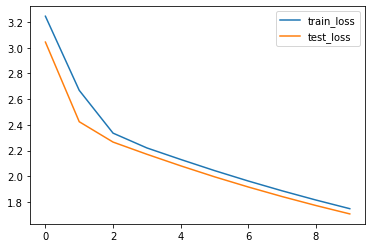

In [11]:
# plot the training and testing loss
plot_loss(train_loss_history, test_loss_history, 'LSTM_Variant')